In [2]:
# --- Imports ---
import kagglehub
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score
)

# --- Configuration ---
# Visual styling
sns.set(style="whitegrid", context="notebook")
pd.set_option('display.max_columns', None)

# Dataset Config
DATASET_REF = "arashnic/fitbit"
SUB_PATH = os.path.join("mturkfitbit_export_4.12.16-5.12.16", "Fitabase Data 4.12.16-5.12.16")
REQUIRED_FILES = [
    "dailyActivity_merged.csv",
    "heartrate_seconds_merged.csv",
    "minuteSleep_merged.csv",
    "weightLogInfo_merged.csv"
]

print("✅ Libraries loaded and configuration set.")

✅ Libraries loaded and configuration set.


In [3]:
def load_data(dataset_ref, sub_path, files):
    print(f"⬇️  Downloading dataset: {dataset_ref}...")
    path = kagglehub.dataset_download(dataset_ref)
    base_path = os.path.join(path, sub_path)
    
    dfs = {}
    for file in files:
        full_path = os.path.join(base_path, file)
        try:
            dfs[file] = pd.read_csv(full_path)
            print(f"   📄 Loaded {file} | Shape: {dfs[file].shape}")
        except Exception as e:
            print(f"   ❌ Error loading {file}: {e}")
    return dfs

# Execute Load
raw_data = load_data(DATASET_REF, SUB_PATH, REQUIRED_FILES)

# Extract specific frames
daily_df = raw_data["dailyActivity_merged.csv"]
heart_df = raw_data["heartrate_seconds_merged.csv"]
sleep_df = raw_data["minuteSleep_merged.csv"]
weight_df = raw_data["weightLogInfo_merged.csv"]

⬇️  Downloading dataset: arashnic/fitbit...


100%|██████████| 43.3M/43.3M [00:02<00:00, 22.4MB/s]

Extracting files...


   📄 Loaded dailyActivity_merged.csv | Shape: (940, 15)
   📄 Loaded heartrate_seconds_merged.csv | Shape: (2483658, 3)
   📄 Loaded minuteSleep_merged.csv | Shape: (188521, 4)
   📄 Loaded weightLogInfo_merged.csv | Shape: (67, 8)


In [3]:
# 1. Daily Activity (Standardize Date)
daily_df['ActivityDate'] = pd.to_datetime(daily_df['ActivityDate']).dt.normalize()

# 2. Heart Rate (Seconds -> Daily Avg)
heart_df['Time'] = pd.to_datetime(heart_df['Time'])
heart_df['ActivityDate'] = heart_df['Time'].dt.normalize()
heart_daily = heart_df.groupby(['Id', 'ActivityDate'])['Value'].mean().reset_index()
heart_daily.rename(columns={'Value': 'AvgHeartRate'}, inplace=True)

# 3. Sleep (Minutes -> Daily Total)
sleep_df['date'] = pd.to_datetime(sleep_df['date'])
sleep_df['ActivityDate'] = sleep_df['date'].dt.normalize()
sleep_daily = sleep_df.groupby(['Id', 'ActivityDate'])['value'].sum().reset_index()
sleep_daily.rename(columns={'value': 'TotalMinutesAsleep'}, inplace=True)

# 4. Weight/BMI (Imputation strategy)
weight_df['Date'] = pd.to_datetime(weight_df['Date'], format="mixed").dt.normalize()
weight_df.rename(columns={'Date': 'ActivityDate'}, inplace=True)
# Sort and fill missing BMI values for users who weigh in sporadically
weight_clean = weight_df[['Id', 'ActivityDate', 'BMI']].sort_values(by=['Id', 'ActivityDate'])
weight_filled = weight_clean.groupby('Id').apply(lambda x: x.ffill().bfill()).reset_index(drop=True)

print("✅ Data preprocessing complete. Ready to merge.")

✅ Data preprocessing complete. Ready to merge.


C:\Users\tanib\AppData\Local\Temp\ipykernel_17304\3675018433.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weight_filled = weight_clean.groupby('Id').apply(lambda x: x.ffill().bfill()).reset_index(drop=True)


In [4]:
# Merge logical flow: Daily <- Heart <- Sleep <- Weight
master_df = daily_df.merge(heart_daily, on=['Id', 'ActivityDate'], how='left')
master_df = master_df.merge(sleep_daily, on=['Id', 'ActivityDate'], how='left')
master_df = master_df.merge(weight_filled, on=['Id', 'ActivityDate'], how='left')

# Final Cleanup (Impute remaining NaNs with column means for the model)
cols_to_fix = ['AvgHeartRate', 'TotalMinutesAsleep', 'BMI']
for col in cols_to_fix:
    master_df[col] = master_df[col].fillna(master_df[col].mean())

print(f"✅ Master DataFrame constructed. Shape: {master_df.shape}")
master_df.head(3)

✅ Master DataFrame constructed. Shape: (940, 18)


,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,AvgHeartRate,TotalMinutesAsleep,BMI
0,1503960366,2016-04-12,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985,78.614059,371.000000,25.185224
1,1503960366,2016-04-13,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797,78.614059,442.000000,25.185224
2,1503960366,2016-04-14,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776,78.614059,466.165533,25.185224


In [5]:
df_eng = master_df.copy()

# Helper: Total Active Minutes
df_eng['ActiveMinutesTotal'] = (df_eng['VeryActiveMinutes'] + 
                                df_eng['FairlyActiveMinutes'] + 
                                df_eng['LightlyActiveMinutes'])

# 1. ActiveRatio (Intensity)
# +1 avoids division by zero
df_eng['ActiveRatio'] = df_eng['VeryActiveMinutes'] / (df_eng['ActiveMinutesTotal'] + 1)

# 2. SedentaryRatio (Inactivity)
df_eng['SedentaryRatio'] = df_eng['SedentaryMinutes'] / (df_eng['SedentaryMinutes'] + df_eng['VeryActiveMinutes'] + 1)

# 3. SleepPerActive (Recovery)
df_eng['SleepPerActive'] = df_eng['TotalMinutesAsleep'] / (df_eng['VeryActiveMinutes'] + 1)

# Drop raw columns used for calculation to reduce noise
drop_cols = ['Id', 'ActivityDate', 'TotalDistance', 'TrackerDistance', 
             'LoggedActivitiesDistance', 'VeryActiveDistance', 'ModeratelyActiveDistance', 
             'LightActiveDistance', 'SedentaryActiveDistance', 'Calories',
             'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 
             'SedentaryMinutes', 'ActiveMinutesTotal']

df_final = df_eng.drop(columns=drop_cols)
print("✅ Features Engineered.")

✅ Features Engineered.


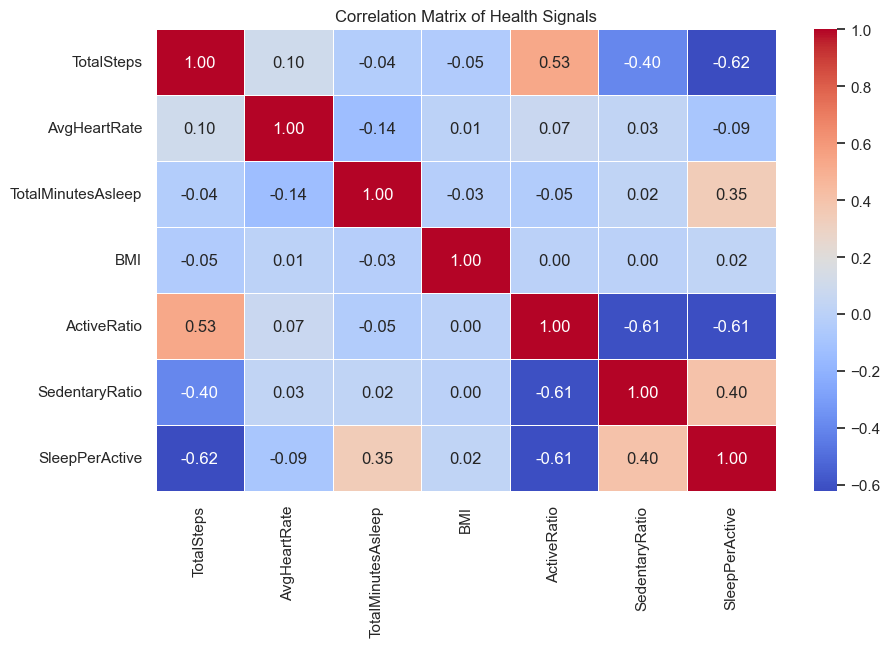

In [6]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_final.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Health Signals")
plt.show()

In [ ]:
# Scale data 0-1 so weights apply evenly
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(df_final), columns=df_final.columns)

# Calculate Hypothetical Risk Score
X_scaled['RiskScore'] = (
    (X_scaled['BMI'] * 0.35) + 
    (X_scaled['SedentaryRatio'] * 0.25) + 
    (X_scaled['AvgHeartRate'] * 0.20) - 
    (X_scaled['SleepPerActive'] * 0.10) - 
    (X_scaled['ActiveRatio'] * 0.10)
)

# Segment into Tiers (Quantiles)
# Low Score -> Gold Tier (0)
# Medium Score -> Silver Tier (1)
# High Score -> Bronze Tier (2)
X_scaled['PremiumTier'] = pd.qcut(X_scaled['RiskScore'], q=3, labels=[0, 1, 2])

# Define X and y
y = X_scaled['PremiumTier'].astype(int)
X = X_scaled.drop(columns=['RiskScore', 'PremiumTier'])

# Map for readability
tier_map = {0: 'Gold (Low Risk)', 1: 'Silver (Med Risk)', 2: 'Bronze (High Risk)'}
print("Distribution of Premium Tiers:")
print(y.map(tier_map).value_counts())

Distribution of Premium Tiers:
PremiumTier
Gold (Low Risk)       314
Bronze (High Risk)    313
Silver (Med Risk)     313
Name: count, dtype: int64


In [8]:
# Split Data (Stratified to maintain tier balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize Model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)

# Train
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Evaluation Metrics
print("--- Model Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Gold', 'Silver', 'Bronze']))

--- Model Performance ---
Accuracy: 92.55%

Classification Report:
              precision    recall  f1-score   support

        Gold       0.92      0.95      0.94        63
      Silver       0.95      0.87      0.91        63
      Bronze       0.91      0.95      0.93        62

    accuracy                           0.93       188
   macro avg       0.93      0.93      0.93       188
weighted avg       0.93      0.93      0.93       188



<Figure size 800x600 with 0 Axes>

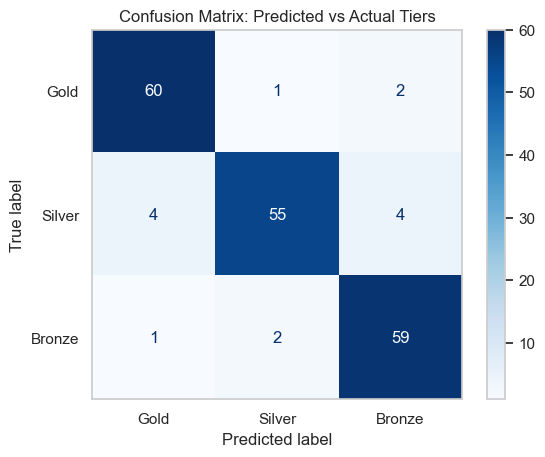

C:\Users\tanib\AppData\Local\Temp\ipykernel_17304\3261174765.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=X.columns[indices], palette="viridis")


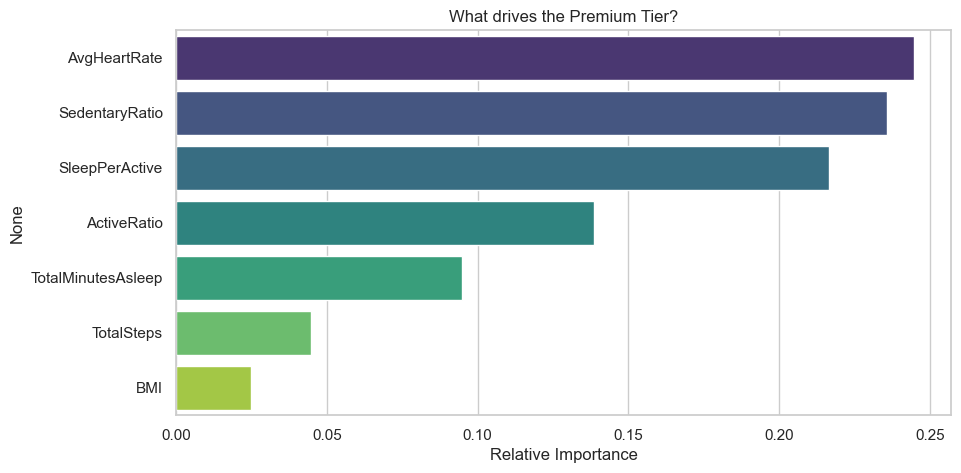

In [9]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Gold', 'Silver', 'Bronze'])

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Predicted vs Actual Tiers")
plt.grid(False)
plt.show()

# 2. Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("What drives the Premium Tier?")
sns.barplot(x=importances[indices], y=X.columns[indices], palette="viridis")
plt.xlabel("Relative Importance")
plt.show()